## Modelo de Predicción Tipo de Cambio MXN - USD

Se presentan dos modelos de **pronóstico** del tipo de cambio de *Dólar Americano (USD)* a *Peso Mexicano (MXN)*, por medio de dos enfoques:

- Modelo Autoregresivo de Series de Tiempo.
- Modelo Autoregresivo de Series de Tiempo con Variables Exógenas.

Los modelos de Series Temporales son una descomposición aditiva / multiplicativa, en la que se identifican y separan tres componentes principales de la serie temporal:

- Tendencia (Trend).
- Estacionalidad (Seasonality).
- Eventos Excepcionales (Vacations / Holidays / Events).
- Residuos (Noise).

La presencia del componente de tendencia permite manejar evoluciones de largo plazo, mientras que la estacionalidad ayuda a capturar variaciones periódicas.

El objetivo es identificar los patrones de correlación temporal que permitan transformar la serie temporal en una serie *estacionaria* en la que puede ajustarse un modelo estadístico.

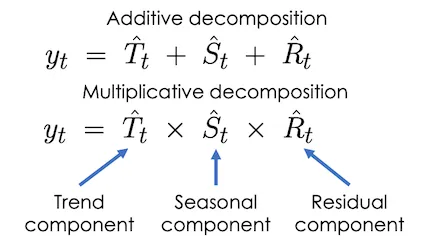


La información de la tasa de cambio, así como de los regresores exógenos son obtenidos del **Banco de Datos del Banco Mundial** (https://databank.worldbank.org/)


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from prophet import Prophet
from prophet.diagnostics import performance_metrics, cross_validation
from prophet.plot import plot_cross_validation_metric

### Dataset

El siguiente conjunto de datos se obtuvo por medio del **Banco de Datos** del *Banco Mundial* (http://databank.worldbank.org/data/reports.aspx?source=2&series=PA.NUS.FCRF&country=) e incluye la siguiente consulta sobre indicadores macroeconómicos anualizados de México de los últimos **30 años**:

- Official exchange rate (LCU per US$, period average)
- GDP growth (annual %)
- Inflation, consumer prices (annual %)
- Current account balance (% of GDP)
- Unemployment, total (% of total labor force) (national estimate)
- Lending interest rate (%)

Obtenidos de la base de datos *World Development Indicators* actualizada el 28/Junio/2024


In [2]:
# .csv Global Key Indicators
mx_df = pd.read_csv("EXMXUS_MULTIVAR.csv")
mx_df['Year'] = pd.to_datetime(mx_df['Year'],format='%Y') + pd.offsets.YearEnd()
mx_df.rename(columns={'Exchange Rate':'y','Year':'ds'},inplace=True)
mx_df

,ds,y,GDP,Inflation,Balance,Unemployment,Interest Rate
0,1993-12-31,3.115617,2.866999,9.751460,-4.413756,3.365,18.225000
1,1994-12-31,3.375117,4.394128,6.965812,-5.357863,4.436,19.300000
2,1995-12-31,6.419425,-5.910300,34.999271,-0.414681,7.095,59.431667
3,1996-12-31,7.599448,6.218297,34.378383,-0.580285,5.465,36.385833
4,1997-12-31,7.918460,7.198876,20.625629,-1.464313,4.235,22.140000
5,1998-12-31,9.136042,6.185079,15.928395,-2.868838,3.733,26.358333
6,1999-12-31,9.560398,2.755030,16.585617,-2.217782,2.598,23.742500
7,2000-12-31,9.455558,5.029284,9.491561,-2.527072,2.646,16.928333
8,2001-12-31,9.342342,-0.450845,6.367738,-2.230034,2.627,12.795000
9,2002-12-31,9.655958,-0.236588,5.030727,-1.529365,3.003,8.210833


### Modelo Serie Temporal Auto-Regresión

Se utiliza la librería Prophet para entrenar el modelo. Se utiliza validación cruzada por ventanas, para determinar cuál es el horizonte óptimo de predicción.

In [3]:
model = Prophet(interval_width = 0.95)
model.fit(mx_df)
df_cv = cross_validation(model, initial='7300 days', period='365 days', horizon = '365 days')
df_cv

11:43:09 - cmdstanpy - INFO - Chain [1] start processing
11:43:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/10 [00:00<?, ?it/s]

11:43:09 - cmdstanpy - INFO - Chain [1] start processing
11:43:09 - cmdstanpy - INFO - Chain [1] done processing
11:43:09 - cmdstanpy - INFO - Chain [1] start processing
11:43:09 - cmdstanpy - INFO - Chain [1] done processing
11:43:09 - cmdstanpy - INFO - Chain [1] start processing
11:43:09 - cmdstanpy - INFO - Chain [1] done processing
11:43:09 - cmdstanpy - INFO - Chain [1] start processing
11:43:09 - cmdstanpy - INFO - Chain [1] done processing
11:43:09 - cmdstanpy - INFO - Chain [1] start processing
11:43:09 - cmdstanpy - INFO - Chain [1] done processing
11:43:09 - cmdstanpy - INFO - Chain [1] start processing
11:43:09 - cmdstanpy - INFO - Chain [1] done processing
11:43:09 - cmdstanpy - INFO - Chain [1] start processing
11:43:10 - cmdstanpy - INFO - Chain [1] done processing
11:43:10 - cmdstanpy - INFO - Chain [1] start processing
11:43:10 - cmdstanpy - INFO - Chain [1] done processing
11:43:10 - cmdstanpy - INFO - Chain [1] start processing
11:43:10 - cmdstanpy - INFO - Chain [1]

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2014-12-31,14.392383,12.199659,16.528628,13.292450,2014-01-02
1,2015-12-31,14.673805,12.467057,16.769064,15.848267,2015-01-02
2,2016-12-31,15.377350,13.221232,17.434199,18.664058,2016-01-02
3,2017-12-31,16.164749,13.933849,18.461452,18.926517,2017-01-01
4,2018-12-31,16.942102,14.449323,19.523554,19.244342,2018-01-01
5,2019-12-31,17.791461,15.136794,20.765003,19.263633,2019-01-01
6,2020-12-31,18.866496,16.292036,21.399562,21.485608,2020-01-01
7,2021-12-31,19.502192,16.725659,22.128912,20.272408,2020-12-31
8,2022-12-31,19.949494,17.498619,22.646490,20.127350,2021-12-31
9,2023-12-31,20.531400,17.907040,23.201047,17.758717,2022-12-31


#### Métricas de Validación Cruzada

In [4]:
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,363 days,1.294607,1.137808,1.137198,0.078428,0.078428,0.078210,1.0
1,364 days,6.474353,2.544475,2.455722,0.129518,0.132776,0.139302,0.5
2,365 days,3.793096,1.947587,1.584967,0.081215,0.079947,0.080561,0.5


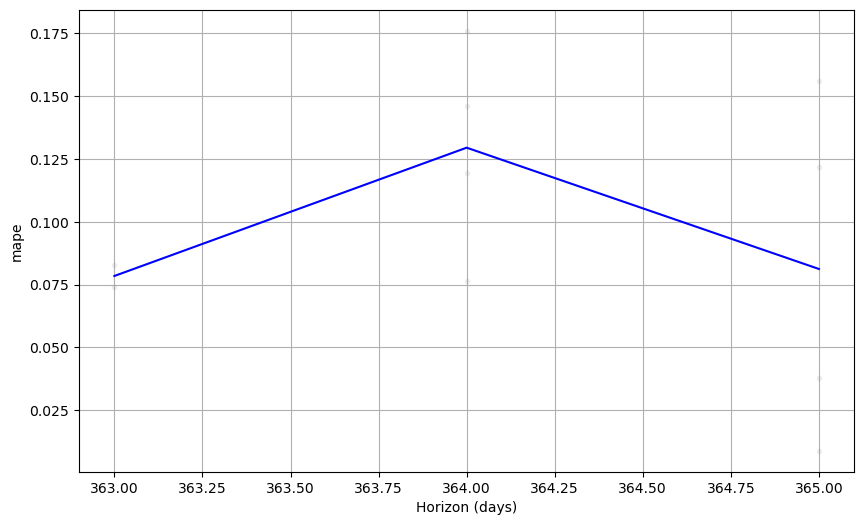

In [5]:
fig = plot_cross_validation_metric(df_cv, metric='mape')

Puede observarse que el horizonte de pronóstico con menor error es a **363 días** con un error porcentual del 7.8%

### Forecasting

Se crea un conjunto de datos para realizar el pronóstico de los **próximos 5 años**, con **intervalos de confianza del 95%** para el estimado.

In [6]:
n_forecast = 5
future = model.make_future_dataframe(periods=n_forecast, freq='Y')
forecast = model.predict(future)
forecast.tail(5)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
31,2024-12-31,22.901819,18.468400,23.974444,22.901807,22.901827,-1.481494,-1.481494,-1.481494,-1.481494,-1.481494,-1.481494,0.0,0.0,0.0,21.420325
32,2025-12-31,23.418899,18.792820,24.381717,23.418861,23.418927,-1.918733,-1.918733,-1.918733,-1.918733,-1.918733,-1.918733,0.0,0.0,0.0,21.500166
33,2026-12-31,23.935979,18.940792,24.210063,23.935914,23.936031,-2.215138,-2.215138,-2.215138,-2.215138,-2.215138,-2.215138,0.0,0.0,0.0,21.720841
34,2027-12-31,24.453059,19.285031,24.918862,24.452961,24.453138,-2.370346,-2.370346,-2.370346,-2.370346,-2.370346,-2.370346,0.0,0.0,0.0,22.082713
35,2028-12-31,24.971555,21.030618,26.248705,24.971422,24.971666,-1.481494,-1.481494,-1.481494,-1.481494,-1.481494,-1.481494,0.0,0.0,0.0,23.490062


In [7]:
forecast[['ds','yhat','yhat_lower','yhat_upper']].tail(5)

,ds,yhat,yhat_lower,yhat_upper
31,2024-12-31,21.420325,18.468400,23.974444
32,2025-12-31,21.500166,18.792820,24.381717
33,2026-12-31,21.720841,18.940792,24.210063
34,2027-12-31,22.082713,19.285031,24.918862
35,2028-12-31,23.490062,21.030618,26.248705


<Figure size 1500x700 with 0 Axes>

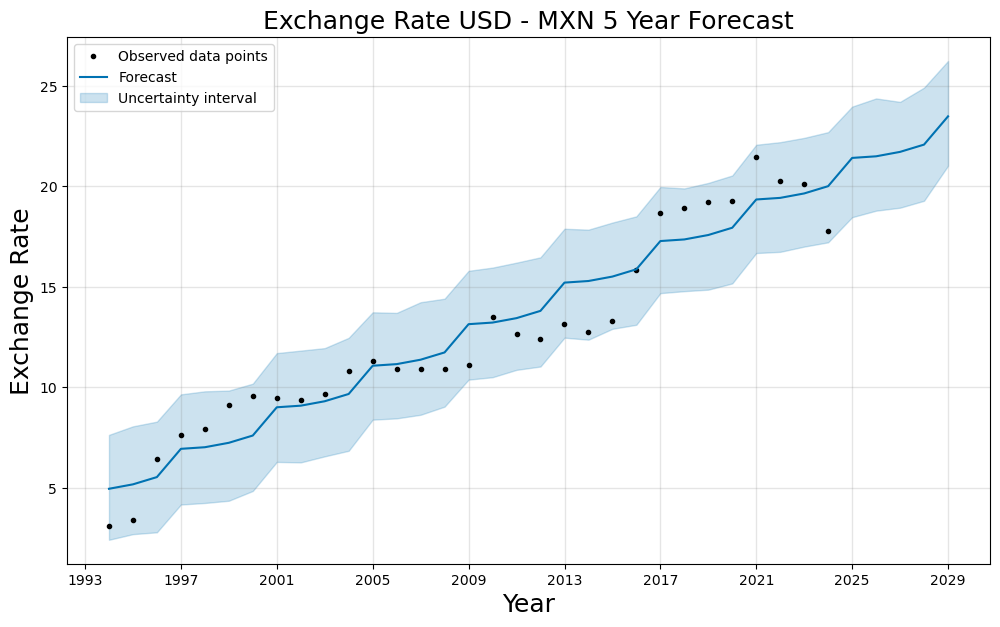

In [8]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", FutureWarning)

    plt.figure(figsize=(15,7))
    model.plot(forecast)
    plt.legend(loc='upper left')
    plt.title("Exchange Rate USD - MXN {} Year Forecast".format(n_forecast) ,  fontsize=18)
    plt.xlabel('Year' ,  fontsize=18)
    plt.ylabel('Exchange Rate' , fontsize=18)

#### Análisis de Componentes: Tendencia + Estacionalidad

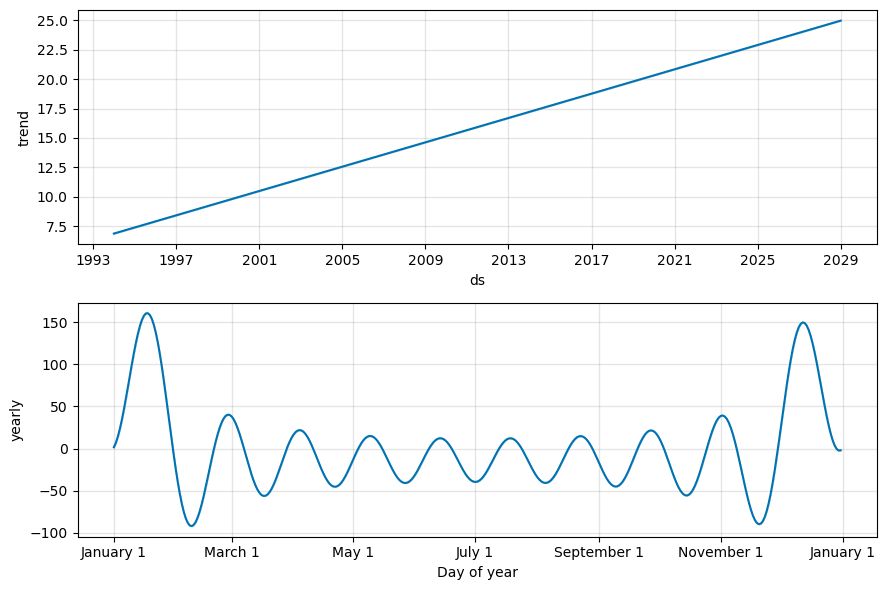

In [9]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", FutureWarning)
    fig = model.plot_components(forecast)

### Modelo Serie Temporal Auto-Regresión con Regresores Exógenos

Se utiliza la librería Prophet para entrenar el modelo, incluyendo **regresores exógenos** que consisten en valores anualizados de variables macroeconómicas de México durante los últimos 30 años

El conjunto de datos se obtuvo por medio del **Banco de Datos** del *Banco Mundial* (http://databank.worldbank.org/data/reports.aspx?source=2&series=PA.NUS.FCRF&country=) e incluye la siguiente consulta sobre indicadores macroeconómicos anualizados de México de los últimos **30 años**:

- Official exchange rate (LCU per US$, period average)
- GDP growth (annual %)
- Inflation, consumer prices (annual %)
- Current account balance (% of GDP)
- Unemployment, total (% of total labor force) (national estimate)
- Lending interest rate (%)

Obtenidos de la base de datos *World Development Indicators* actualizada el 28/Junio/2024


Se utiliza validación cruzada por ventanas, para determinar cuál es el horizonte óptimo de predicción.

In [10]:
model = Prophet(interval_width = 0.95)
model.add_regressor('GDP',standardize=True)
model.add_regressor('Inflation',standardize=True)
model.add_regressor('Balance',standardize=True)
model.add_regressor('Unemployment',standardize=True)
model.add_regressor('Interest Rate',standardize=True)
model.fit(mx_df)
df_cv = cross_validation(model, initial='7300 days', period='365 days', horizon = '365 days')
df_cv

11:43:10 - cmdstanpy - INFO - Chain [1] start processing
11:43:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/10 [00:00<?, ?it/s]

11:43:10 - cmdstanpy - INFO - Chain [1] start processing
11:43:10 - cmdstanpy - INFO - Chain [1] done processing
11:43:10 - cmdstanpy - INFO - Chain [1] start processing
11:43:11 - cmdstanpy - INFO - Chain [1] done processing
11:43:11 - cmdstanpy - INFO - Chain [1] start processing
11:43:11 - cmdstanpy - INFO - Chain [1] done processing
11:43:11 - cmdstanpy - INFO - Chain [1] start processing
11:43:11 - cmdstanpy - INFO - Chain [1] done processing
11:43:11 - cmdstanpy - INFO - Chain [1] start processing
11:43:11 - cmdstanpy - INFO - Chain [1] done processing
11:43:11 - cmdstanpy - INFO - Chain [1] start processing
11:43:11 - cmdstanpy - INFO - Chain [1] done processing
11:43:11 - cmdstanpy - INFO - Chain [1] start processing
11:43:11 - cmdstanpy - INFO - Chain [1] done processing
11:43:11 - cmdstanpy - INFO - Chain [1] start processing
11:43:11 - cmdstanpy - INFO - Chain [1] done processing
11:43:11 - cmdstanpy - INFO - Chain [1] start processing
11:43:11 - cmdstanpy - INFO - Chain [1]

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2014-12-31,13.915557,12.533845,15.351665,13.292450,2014-01-02
1,2015-12-31,13.855621,12.500557,15.170886,15.848267,2015-01-02
2,2016-12-31,15.559092,14.084923,17.051743,18.664058,2016-01-02
3,2017-12-31,18.182715,16.638912,19.824444,18.926517,2017-01-01
4,2018-12-31,18.965519,17.152783,20.686196,19.244342,2018-01-01
5,2019-12-31,19.746310,18.007081,21.398183,19.263633,2019-01-01
6,2020-12-31,20.422251,18.783896,22.136127,21.485608,2020-01-01
7,2021-12-31,20.472362,18.748421,22.192724,20.272408,2020-12-31
8,2022-12-31,21.849241,20.238709,23.481818,20.127350,2021-12-31
9,2023-12-31,22.539246,20.902409,24.132689,17.758717,2022-12-31


#### Métricas de Validación Cruzada

In [11]:
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,363 days,2.179449,1.476296,1.307876,0.086305,0.086305,0.089985,0.50
1,364 days,2.626194,1.620554,1.152567,0.061301,0.032178,0.065220,0.75
2,365 days,6.747269,2.597551,1.941433,0.103525,0.067521,0.094965,0.50


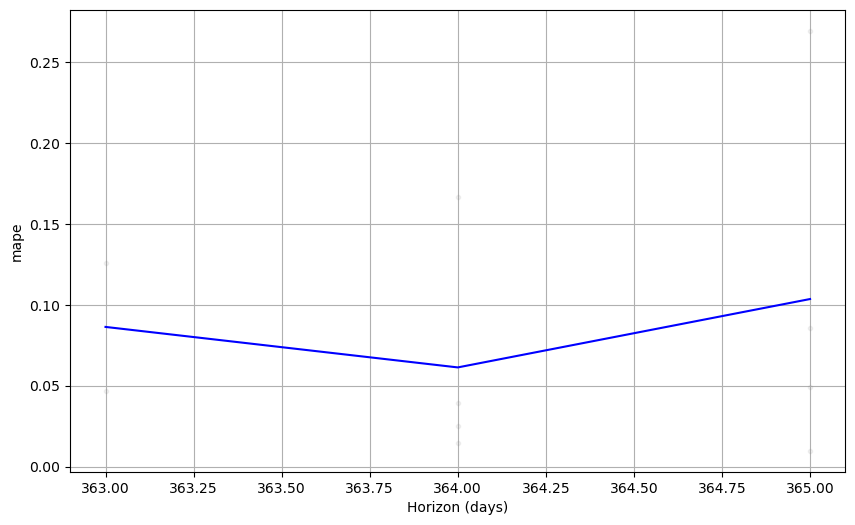

In [12]:
fig = plot_cross_validation_metric(df_cv, metric='mape')

Puede observarse que el horizonte de pronóstico con menor error es a **364 días** con un error porcentual del 6.1%

### Forecasting

Se crea un conjunto de datos para realizar el pronóstico de los **próximos 5 años**, con **intervalos de confianza del 95%** para el estimado.
Para poder hacer el pronóstico, se necesita del **pronóstico de los regresores exógenos** para este horizonte de tiempo. Para ello se utiliza el ***One-Click Report: México*** del Economist Intelligence Unit (EIU) para el 6 de Mayo de 2024 (https://www.eiu.com/n/).

In [13]:
# .csv Global Key Indicators Forecasts
mx_df_ext = pd.read_csv("EXREGR.csv")
mx_df_ext['Year'] = pd.to_datetime(mx_df_ext['Year'],format='%Y') + pd.offsets.YearEnd()
mx_df_ext.rename(columns={'Exchange Rate':'y','Year':'ds'},inplace=True)
mx_df_ext

,ds,GDP,Inflation,Balance,Unemployment,Interest Rate
0,2024-12-31,2.3,4.4,-0.4,3.0,11.2
1,2025-12-31,2.3,3.6,-0.7,3.1,9.9
2,2026-12-31,2.1,3.3,-1.1,3.3,8.8
3,2027-12-31,2.2,3.2,-1.3,3.3,7.9
4,2028-12-31,2.2,3.1,-1.6,3.3,7.6


In [14]:
n_forecast = 5
future = pd.concat([mx_df,mx_df_ext],axis=0)
forecast_ext = model.predict(future)
forecast_ext.tail(5)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Balance,Balance_lower,Balance_upper,GDP,...,extra_regressors_additive,extra_regressors_additive_lower,extra_regressors_additive_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
31,2024-12-31,14.642507,19.921876,24.062306,14.642501,14.642513,0.218531,0.218531,0.218531,-0.028826,...,0.428704,0.428704,0.428704,6.936439,6.936439,6.936439,0.0,0.0,0.0,22.007650
32,2025-12-31,15.177803,19.886532,24.123285,15.177787,15.177820,0.153930,0.153930,0.153930,-0.028826,...,0.214390,0.214390,0.214390,6.711026,6.711026,6.711026,0.0,0.0,0.0,22.103218
33,2026-12-31,15.713099,20.048843,24.418898,15.713067,15.713132,0.067795,0.067795,0.067795,-0.003902,...,-0.003522,-0.003522,-0.003522,6.437760,6.437760,6.437760,0.0,0.0,0.0,22.147337
34,2027-12-31,16.248395,20.200277,24.499739,16.248347,16.248445,0.024727,0.024727,0.024727,-0.016364,...,-0.041269,-0.041269,-0.041269,6.116937,6.116937,6.116937,0.0,0.0,0.0,22.324063
35,2028-12-31,16.785157,21.480075,25.685583,16.785091,16.785227,-0.039874,-0.039874,-0.039874,-0.016364,...,-0.110082,-0.110082,-0.110082,6.936439,6.936439,6.936439,0.0,0.0,0.0,23.611515


In [15]:
forecast_ext[['ds','yhat','yhat_lower','yhat_upper']].tail(5)

,ds,yhat,yhat_lower,yhat_upper
31,2024-12-31,22.007650,19.921876,24.062306
32,2025-12-31,22.103218,19.886532,24.123285
33,2026-12-31,22.147337,20.048843,24.418898
34,2027-12-31,22.324063,20.200277,24.499739
35,2028-12-31,23.611515,21.480075,25.685583


<Figure size 1500x700 with 0 Axes>

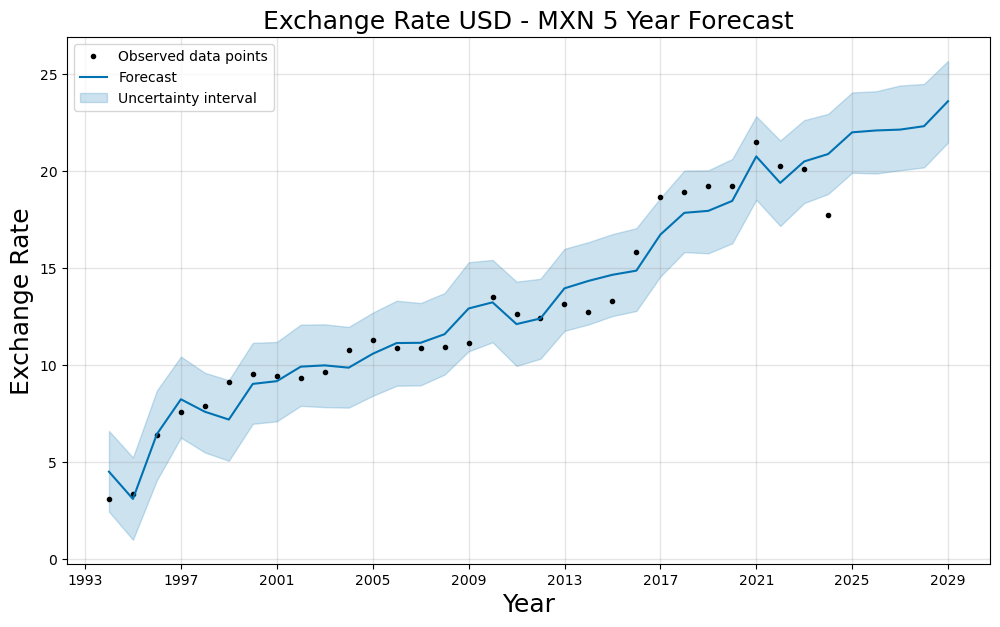

In [16]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", FutureWarning)

    plt.figure(figsize=(15,7))
    model.plot(forecast_ext)
    plt.legend(loc='upper left')
    plt.title("Exchange Rate USD - MXN {} Year Forecast".format(n_forecast) ,  fontsize=18)
    plt.xlabel('Year' ,  fontsize=18)
    plt.ylabel('Exchange Rate' , fontsize=18)

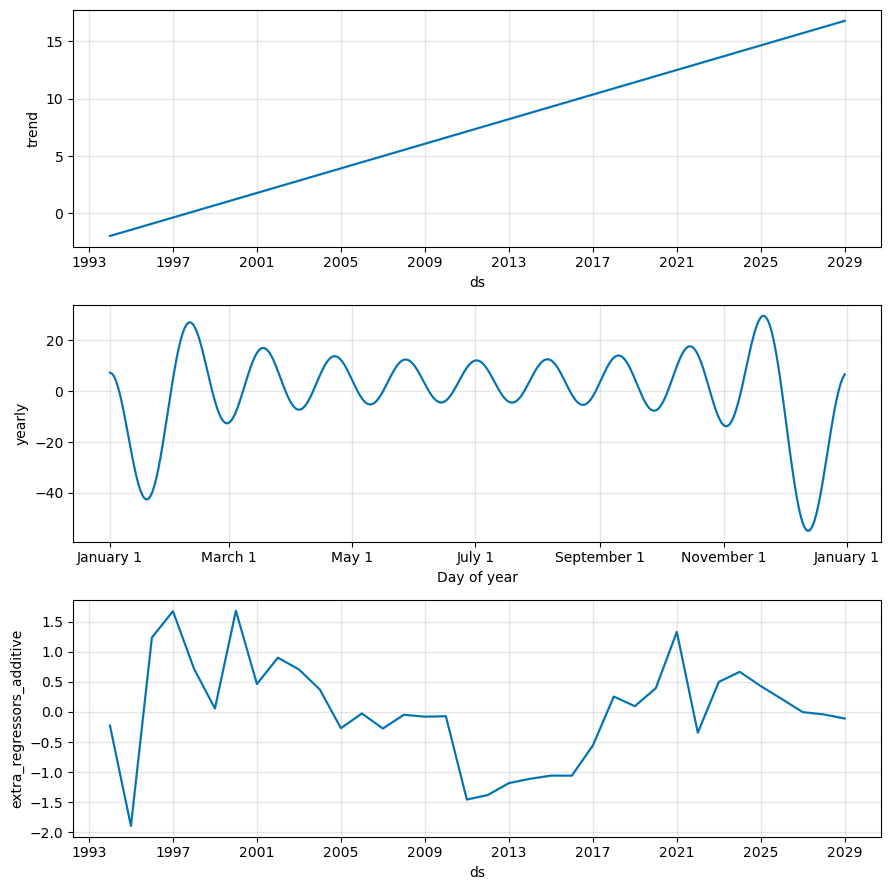

In [17]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", FutureWarning)
    model.plot_components(forecast_ext)

### Resumen Resultados

#### Serie Temporal Simple

In [18]:
serie_temporal = forecast[['ds','yhat','yhat_lower','yhat_upper']].tail(5)
serie_temporal.rename(columns={"yhat": "Tasa", "yhat_lower": "LI 95% Confianza", "yhat_upper": "LS 95% Confianza"})

,ds,Tasa,LI 95% Confianza,LS 95% Confianza
31,2024-12-31,21.420325,18.468400,23.974444
32,2025-12-31,21.500166,18.792820,24.381717
33,2026-12-31,21.720841,18.940792,24.210063
34,2027-12-31,22.082713,19.285031,24.918862
35,2028-12-31,23.490062,21.030618,26.248705


#### Serie Temporal con Regresores

In [19]:
serie_temporal = forecast_ext[['ds','yhat','yhat_lower','yhat_upper']].tail(5)
serie_temporal.rename(columns={"yhat": "Tasa", "yhat_lower": "LI 95% Confianza", "yhat_upper": "LS 95% Confianza"})

,ds,Tasa,LI 95% Confianza,LS 95% Confianza
31,2024-12-31,22.007650,19.921876,24.062306
32,2025-12-31,22.103218,19.886532,24.123285
33,2026-12-31,22.147337,20.048843,24.418898
34,2027-12-31,22.324063,20.200277,24.499739
35,2028-12-31,23.611515,21.480075,25.685583
